In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [11]:
import requests
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
loca_filename = "../data/jena_climate_2009_2016.csv.zip"
response = requests.get(url,stream = True)



In [2]:

loca_filename = "../data/jena_climate_2009_2016.csv.zip"
with open(loca_filename,"wb") as f:
    for chunk in response.iter_content(chunk_size= 128):
        f.write(chunk)
        

NameError: name 'response' is not defined

In [4]:
import zipfile 

loca_filename = "../data/jena_climate_2009_2016.csv.zip"
with zipfile.ZipFile(loca_filename, "r") as zip_ref:
        zip_ref.extractall("../data")
        

BadZipFile: File is not a zip file

In [5]:
import pandas as pd
data_location = "../data/jena_climate_2009_2016.csv"
# pd.read_csv(data_location)

In [6]:
with open(data_location ) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [7]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]                       
    raw_data[i, :] = values[:] 

In [8]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [9]:
temperature.shape

(420451,)

In [10]:
raw_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [11]:
raw_data.shape

(420451, 14)

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [13]:
# Normalize
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data [:num_train_samples].std(axis = 0)
raw_data /= std

In [14]:
# create dataset
import keras
sampling_rate = 6 
sequence_length = 120 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 
  
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [15]:
(sequence_length,raw_data.shape[-1])

(120, 14)

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]         
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
  
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [17]:
from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",          
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")              
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")   

Epoch 1/10
819/819 [==============================] - 5s 5ms/step - loss: 14.6224 - mae: 2.9444 - val_loss: 13.2879 - val_mae: 2.9079
Epoch 2/10
819/819 [==============================] - 4s 5ms/step - loss: 9.8539 - mae: 2.4728 - val_loss: 10.2281 - val_mae: 2.5240
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 9.0206 - mae: 2.3656 - val_loss: 10.4416 - val_mae: 2.5482
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 8.4772 - mae: 2.2935 - val_loss: 11.3376 - val_mae: 2.6808
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 8.0892 - mae: 2.2406 - val_loss: 11.9580 - val_mae: 2.7633
Epoch 6/10
819/819 [==============================] - 4s 5ms/step - loss: 7.7762 - mae: 2.1993 - val_loss: 10.8051 - val_mae: 2.6175
Epoch 7/10
819/819 [==============================] - 4s 5ms/step - loss: 7.5338 - mae: 2.1635 - val_loss: 11.4045 - val_mae: 2.6985
Epoch 8/10
819/819 [==============================] - 4s 5ms/step - 

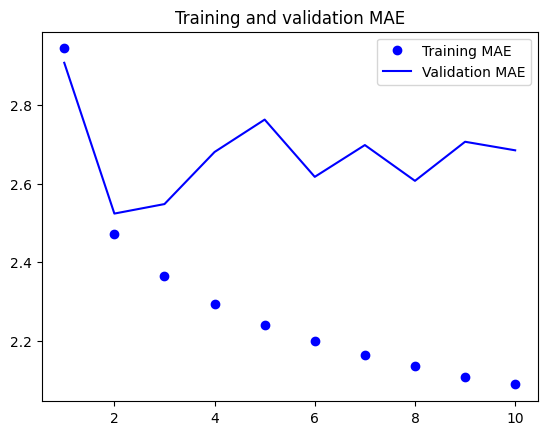

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
# using COVN1D:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 5ms/step - loss: 23.4450 - mae: 3.8027 - val_loss: 20.3207 - val_mae: 3.5414
Epoch 2/10
819/819 [==============================] - 4s 5ms/step - loss: 16.3277 - mae: 3.2073 - val_loss: 14.9984 - val_mae: 3.0486
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 14.8601 - mae: 3.0646 - val_loss: 15.0129 - val_mae: 3.0494
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 14.0540 - mae: 2.9722 - val_loss: 17.0884 - val_mae: 3.2472
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 13.3823 - mae: 2.8938 - val_loss: 17.4523 - val_mae: 3.2650
Epoch 6/10
819/819 [==============================] - 4s 5ms/step - loss: 12.8424 - mae: 2.8291 - val_loss: 15.0508 - val_mae: 3.0392
Epoch 7/10
819/819 [==============================] - 5s 6ms/step - loss: 12.4129 - mae: 2.7792 - val_loss: 14.7618 - val_mae: 3.0059
Epoch 8/10
819/819 [==============================] - 5s 6ms/s

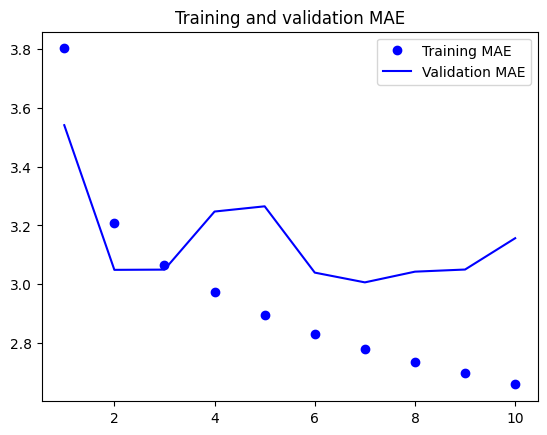

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 9ms/step - loss: 45.8874 - mae: 4.9454 - val_loss: 13.4532 - val_mae: 2.7399
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 11.1196 - mae: 2.5824 - val_loss: 9.9799 - val_mae: 2.4501
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 9.7709 - mae: 2.4351 - val_loss: 9.6581 - val_mae: 2.4214
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 9.3580 - mae: 2.3805 - val_loss: 10.1023 - val_mae: 2.4862
Epoch 5/10
819/819 [==============================] - 8s 9ms/step - loss: 9.0604 - mae: 2.3406 - val_loss: 9.4848 - val_mae: 2.4026
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 8.7909 - mae: 2.3016 - val_loss: 9.7577 - val_mae: 2.4317
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 8.5810 - mae: 2.2703 - val_loss: 9.9379 - val_mae: 2.4597
Epoch 8/10
819/819 [==============================] - 9s 11ms/step - lo